# Day 2: LangChain vs. LangGraph - The Self-Correcting AI Researcher

**Objective:** To understand the practical differences between a standard `AgentExecutor` and `LangGraph` for building complex, stateful AI agents.

In this notebook, we will attempt to build an agent with a crucial capability: **self-correction**. The agent's task is to research a topic, but with a twist. It must:
1. Perform an initial web search.
2. **Analyze** its own search results to see if they are good enough.
3. If the results are poor, it must **rewrite** its search query and try again.
4. Only when it has sufficient information should it provide a final answer.

This cyclical, self-evaluating behavior is a hallmark of more advanced, reliable agents. We will see how a standard agent struggles with this task and how LangGraph is explicitly designed to solve it.

## 1. Setup and Dependencies

First, let's install the necessary libraries. We will use `ddgs` for DuckDuckGo search as the older package is deprecated. Then we'll import our modules and set up the environment. Make sure you have a `.env` file in the same directory with your `OPENAI_API_KEY`, or set it up as a secret in your Colab environment.

In [1]:
pip install -U langchain langchain-openai langgraph langchain_community ddgs python-dotenv

  Using cached langchain-1.0.3-py3-none-any.whl (91 kB)
  Using cached langchain_openai-1.0.2-py3-none-any.whl (81 kB)
  Using cached langgraph-1.0.2-py3-none-any.whl (156 kB)
  Using cached langchain_community-0.4.1-py3-none-any.whl (2.5 MB)
  Using cached ddgs-9.7.1-py3-none-any.whl (42 kB)
  Using cached python_dotenv-1.2.1-py3-none-any.whl (21 kB)
  Using cached langchain_core-1.0.3-py3-none-any.whl (469 kB)
  Using cached pydantic-2.12.3-py3-none-any.whl (462 kB)
  Using cached openai-2.7.1-py3-none-any.whl (1.0 MB)
  Using cached tiktoken-0.12.0-cp311-cp311-win_amd64.whl (879 kB)
  Using cached langgraph_checkpoint-3.0.1-py3-none-any.whl (46 kB)
  Using cached langgraph_prebuilt-1.0.2-py3-none-any.whl (34 kB)
  Using cached langgraph_sdk-0.2.9-py3-none-any.whl (56 kB)
  Using cached xxhash-3.6.0-cp311-cp311-win_amd64.whl (31 kB)
  Using cached langchain_classic-1.0.0-py3-none-any.whl (1.0 MB)
  Using cached sqlalchemy-2.0.44-cp311-cp311-win_amd64.whl (2.1 MB)
  Using cached aioht


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
from dotenv import load_dotenv

dotenv_path = os.path.expanduser("~/dev.env")
load_dotenv(dotenv_path, override=True)

print("Dependencies installed and environment loaded.")

Dependencies installed and environment loaded.


---

## Part 1: The LangChain Agent Attempt (The Brittle Approach)

Here, we'll try to force a standard `AgentExecutor` to perform the self-correction loop by cramming all the logic into a complex prompt. We are essentially *telling* the agent to follow our steps, but we cannot *enforce* it.

**Hypothesis:** The agent will likely struggle to follow the cyclical instructions. It is heavily biased towards moving forward to a `Final Answer` and may ignore the command to loop back, especially if the initial results are weak.

### 1.1: Define Tools and LLM

In [14]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun

# Tool: The agent only has one tool, a web search.
search_tool = DuckDuckGoSearchRun()
tools = [search_tool]

# LLM: Using a powerful model to give it the best chance.
llm = ChatOpenAI(model="gpt-4o", temperature=0)

### 1.2: The Complex Prompt

This is the core of the attempt. We modify a standard ReAct prompt to include a detailed, multi-step procedure. The agent's ability to follow these instructions is entirely dependent on the LLM's interpretation, making it unreliable.

In [6]:
!python -V

Python 3.11.0


In [7]:
pip show langchain langchain-openai langgraph langchain_community ddgs python-dotenv

Name: langchain
Version: 1.0.3
Summary: Building applications with LLMs through composability
Home-page: 
Author: 
Author-email: 
License: MIT
Location: c:\venv311\Lib\site-packages
Requires: langchain-core, langgraph, pydantic
Required-by: 
---
Name: langchain-openai
Version: 1.0.2
Summary: An integration package connecting OpenAI and LangChain
Home-page: 
Author: 
Author-email: 
License: MIT
Location: c:\venv311\Lib\site-packages
Requires: langchain-core, openai, tiktoken
Required-by: 
---
Name: langgraph
Version: 1.0.2
Summary: Building stateful, multi-actor applications with LLMs
Home-page: 
Author: 
Author-email: 
License: 
Location: c:\venv311\Lib\site-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk, pydantic, xxhash
Required-by: langchain
---
Name: langchain-community
Version: 0.4.1
Summary: Community contributed LangChain integrations.
Home-page: 
Author: 
Author-email: 
License: MIT
Location: c:\venv311\Lib\site-packages
Requires: aio

In [1]:
from langchainhub import hub

ImportError: cannot import name 'hub' from 'langchainhub' (c:\venv311\Lib\site-packages\langchainhub\__init__.py)

In [9]:
pip install langchainhub

  Using cached langchainhub-0.1.21-py3-none-any.whl (5.2 kB)
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
  Using cached types_requests-2.32.4.20250913-py3-none-any.whl (20 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from langchain import hub

# Pull a base ReAct prompt
prompt_template = hub.pull("hwchase17/react").copy()

# Manually inject our complex, cyclical instructions
prompt_template.template = """
You are an expert web researcher. Your goal is to provide a comprehensive answer. You MUST follow these steps precisely:

Step 1: Initial Search. Use the search tool with a query based on the user's topic.
Step 2: Critical Analysis. After getting the search results, you MUST pause and analyze them. Ask yourself: 'Are these results detailed enough to write a good answer?'
Step 3: Decision and Self-Correction. 
- If the results ARE sufficient, proceed to Step 4.
- If the results ARE NOT sufficient, you MUST formulate a new, more specific search query and go back to Step 1. This is a critical self-correction step.

Step 4: Final Answer. Once you have sufficient information, synthesize it into a final, detailed answer.

You have access to the following tools:
{tools}

Use the following format:
Question: the input question you must answer
Thought: your reasoning and plan for the next action (following the steps above)
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat multiple times)
Thought: I now have enough information to answer the user's question.
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}
"""


ImportError: cannot import name 'hub' from 'langchain' (c:\venv311\Lib\site-packages\langchain\__init__.py)

### 1.3: Create and Run the Agent

Now we assemble the agent and run it. Observe the `verbose` output carefully to see if it follows our instructions. The final output will be rendered as Markdown.

In [4]:
from IPython.display import display, Markdown

# Let's run it with a niche topic that likely requires re-searching
topic = "The impact of LangGraph on multi-agent system reliability compared to traditional agent loops"


### 1.4: Analysis of the LangChain Agent's Performance

You will likely observe that the agent performs one search and then immediately proceeds to a `Final Answer`, even if the results are clearly insufficient. It fails to follow the instruction to loop back.

**The core problem is the lack of control.** We are *suggesting* a workflow in the prompt, but the `AgentExecutor`'s fundamental design doesn't support enforcing this kind of cycle. This is a classic example of a workflow that is **not feasible** to implement reliably with this architecture.

---

## Part 2: The LangGraph Solution (The Robust Approach)

Now, let's build the same agent using LangGraph. Instead of a complex prompt, we will define our workflow as an explicit graph of nodes and edges.

**Hypothesis:** The LangGraph implementation will reliably execute the self-correction loop every time it's needed, because the flow is enforced by code, not suggested by a prompt.

### 2.1: Define the State

The `State` is a central concept in LangGraph. It's a single object (in this case, a dictionary) that gets passed between all the nodes in our graph. Each node can read from it and write to it, allowing us to track our progress through the workflow.

In [5]:
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    """Represents the state of our research agent."""
    topic: str
    messages: Annotated[List[BaseMessage], lambda x, y: x + y]
    search_results: str | None
    retries: int

### 2.2: Define the Graph Nodes

Nodes are the fundamental building blocks of a LangGraph workflow. Each node is a simple Python function that receives the current `state` and returns a dictionary containing the values to update in the state.

#### Node 1: `initial_search_node`
This node performs the first web search based on the initial topic and initializes our retry counter.

In [6]:
def initial_search_node(state: AgentState):
    print("---NODE: Initial Search---")
    search_results = search_tool.run(state['topic'])
    return {"search_results": search_results, "retries": 0}

#### Node 2: `analyze_results_node` (Improved Logic)

This node uses the LLM to act as a judge. **This is the improved version.** It now explicitly checks if the search tool failed. If so, it immediately decides the results are `insufficient`, making the agent more robust.

In [7]:
from langchain_core.messages import SystemMessage

def analyze_results_node(state: AgentState):
    print("---NODE: Analyze Results---")
    search_results = state['search_results']
    
    # Check for a failed search result explicitly.
    if not search_results or "No good DuckDuckGo Search Result was found" in search_results:
        print("Analysis Decision: Search failed, results are insufficient.")
        return {"messages": [SystemMessage(content="Analysis: insufficient")]}

    analysis_prompt = f"""You are an expert researcher. Analyze these search results for the topic '{state['topic']}' and determine if they are sufficient to write a comprehensive answer. Respond with only 'sufficient' or 'insufficient'.\n\nResults:\n{state['search_results']}"""
    response = llm.invoke(analysis_prompt)
    decision = response.content.strip().lower()
    print(f"Analysis Decision: {decision}")
    return {"messages": [SystemMessage(content=f"Analysis: {decision}")]}

#### Node 3: `rewrite_query_node`

This node is only called if the analysis fails. It uses the LLM to generate a *better* search query and then executes the search again, updating the state with the new results.

In [8]:
def rewrite_query_node(state: AgentState):
    print("---NODE: Rewrite Query---")
    retries = state['retries']
    rewrite_prompt = f"""You are a search expert. Your search for '{state['topic']}' was insufficient. Rewrite it into a better, more specific search query."""
    new_query = llm.invoke(rewrite_prompt).content.strip()
    print(f"New Query: {new_query}")
    search_results = search_tool.run(new_query)
    return {"search_results": search_results, "retries": retries + 1}

#### Node 4: `final_response_node`

This is the final step, only reached when the results are deemed sufficient. It synthesizes all the gathered information into a comprehensive answer.

In [9]:
def final_response_node(state: AgentState):
    print("---NODE: Final Response---")
    response_prompt = f"""Based on the following search results, provide a detailed answer to the topic: '{state['topic']}'.\n\nResults:\n{state['search_results']}"""
    final_response = llm.invoke(response_prompt).content
    return {"messages": [SystemMessage(content=final_response)]}

### 2.3: Define the Edges and Assemble the Graph

Edges connect our nodes. A **conditional edge** is a special type of edge that uses a function to decide which node to go to next based on the current state. This is how we create our self-correction loop.

In [10]:
from langgraph.graph import StateGraph, END

# This function is our conditional edge.
def should_continue_edge(state: AgentState):
    # First, check for the max retries condition to prevent infinite loops
    if state['retries'] > 2:
        print("---DECISION: Max retries reached, ending.---")
        return "end"
    
    # Check the analysis message in the state
    last_message = state['messages'][-1].content
    if "insufficient" in last_message:
        print("---DECISION: Results are insufficient, rewriting query.---")
        return "rewrite"
    else:
        print("---DECISION: Results are sufficient, generating final response.---")
        return "end"

# Assemble the graph
workflow = StateGraph(AgentState)
workflow.add_node("initial_search", initial_search_node)
workflow.add_node("analyze_results", analyze_results_node)
workflow.add_node("rewrite_query", rewrite_query_node)
workflow.add_node("final_response", final_response_node)

workflow.set_entry_point("initial_search")
workflow.add_edge("initial_search", "analyze_results")
workflow.add_edge("rewrite_query", "analyze_results") # The crucial loop!
workflow.add_conditional_edges(
    "analyze_results",
    should_continue_edge,
    {"rewrite": "rewrite_query", "end": "final_response"} # This dictionary maps the edge function's return value to a node name
)
workflow.add_edge("final_response", END)

app = workflow.compile()
print("Graph compiled successfully!")

Graph compiled successfully!


### 2.4: Visualize the Graph

One of the best features of LangGraph is the ability to visualize your agent's structure. This makes it incredibly easy to understand and debug the flow.

**Note:** This requires `graphviz` and its development libraries to be installed. The command below handles this for Debian-based systems like Google Colab.

In [11]:
pip install -q pygraphviz

Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [88 lines of output]
  C:\Users\adminuser\AppData\Local\Temp\pip-build-env-6sz1kilr\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
  !!
  
          ********************************************************************************
          Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
  
          By 2026-Feb-18, you need to update your project and remove deprecated calls
          or your builds will no longer be supported.
  
          See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
          ********************************************************************************
  
  !!
    corresp(dist, value, root_dir)
  C:\Users\adminuser\AppData\Local\Temp\pi

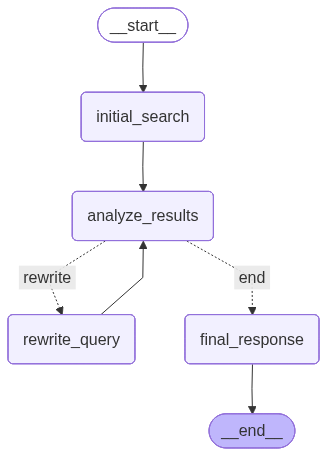

In [12]:
# Install system dependencies for visualization
#!sudo apt-get -qq install -y graphviz libgraphviz-dev


from IPython.display import Image, display

try:
    # Generate the visualization
    graph_image = app.get_graph().draw_mermaid_png()
    display(Image(graph_image))
except Exception as e:
    print(f"Error generating visualization: {e}")
    print("Please ensure graphviz and its development libraries are installed correctly.")

### 2.5: Run the Graph and Observe the State

Now we run our compiled graph. We will `stream` the events to inspect the **interim state** after each node runs. We also pass a `config` dictionary to set a higher recursion limit, preventing the `GraphRecursionError`.

In [13]:
initial_input = {"topic": topic, "messages": []}
config = {"recursion_limit": 50} # Set a higher limit for safety

print("--- Running LangGraph App ---")
for i, step in enumerate(app.stream(initial_input, config=config)):
    # The 'step' object contains the output of the node that just ran
    node_name = list(step.keys())[0]
    node_output = step[node_name]
    
    print(f"\n--- STEP {i+1}: Executed Node '{node_name}' ---")
    print("Output of this node:")
    print(node_output)
    print("-" * 60)

# Get the final state to print the answer
final_state = app.invoke(initial_input, config=config)

print("\n" + "="*50)
print("          LANGGRAPH FINAL ANSWER")
print("="*50)
display(Markdown(final_state['messages'][-1].content))

--- Running LangGraph App ---
---NODE: Initial Search---

--- STEP 1: Executed Node 'initial_search' ---
Output of this node:
{'search_results': 'March 14, 2025 - By addressing limitations like agent looping and introducing more flexible goal-setting mechanisms, it could move closer to becoming a true agentic framework while maintaining its advantages in transparency and predictability. To gauge LangGraph’s real-world impact, it helps to examine feedback from developers and case studies of LangGraph in production environments. Multi - agent systems require more advanced frameworks to manage contextual data, track interactions, and synchronize historical records across agents .Testing multi - agent travel assistant Figure 3: LangGraph studio with Destination Agent recommendation. August 21, 2025 - It allows developers to create more robust and resilient AI systems that are less prone to errors and easier to debug. This means faster development and delivery cycles, more reliable applicat

LangGraph is a framework designed to enhance the reliability and efficiency of multi-agent systems (MAS) by improving the orchestration and collaboration of AI agents. In traditional agent loops, each agent operates in a relatively isolated manner, focusing on its specific tasks with limited interaction or coordination with other agents. This can lead to inefficiencies and reliability issues, especially when complex tasks require seamless collaboration among multiple agents.

**Impact of LangGraph on Multi-Agent System Reliability:**

1. **Enhanced Orchestration:**
   LangGraph provides a structured approach to orchestrating multiple AI agents, ensuring that each agent is not only focused on its specific task but also works in harmony with others. This orchestration is crucial for maintaining system reliability, as it reduces the chances of conflicts and redundancies that can occur when agents operate independently.

2. **Integration of Moderation and Quality Loops:**
   One of the key features of LangGraph is its integration of moderation and quality loops. These loops serve as checkpoints that continuously monitor and evaluate the performance of each agent, ensuring they adhere to their objectives and maintain high-quality outputs. This continuous feedback mechanism helps in promptly identifying and rectifying any deviations or errors, thereby enhancing the overall reliability of the system.

3. **Specialized Agent Collaboration:**
   LangGraph facilitates multi-agent collaboration by allowing each agent to handle specific network functions. This specialization ensures that tasks are performed by the most suitable agents, optimizing performance and reliability. By leveraging the strengths of each agent, LangGraph minimizes the risk of system failures and enhances the robustness of the MAS.

4. **Enterprise Application Requirements:**
   In enterprise settings, additional requirements such as secure data access and system integration are critical. LangGraph addresses these needs by providing a framework that supports secure and efficient data handling, ensuring that agents can access and process information without compromising system integrity. This is particularly important for maintaining reliability in environments where data security and compliance are paramount.

5. **Scalability and Flexibility:**
   LangGraph's design allows for scalability and flexibility, enabling the system to adapt to changing requirements and workloads. This adaptability is crucial for maintaining reliability in dynamic environments where the demand for resources and the nature of tasks can vary significantly.

In summary, LangGraph significantly enhances the reliability of multi-agent systems compared to traditional agent loops by providing a robust framework for agent orchestration, integrating quality control mechanisms, facilitating specialized collaboration, and meeting enterprise-level requirements. These improvements ensure that the system can perform complex tasks efficiently and reliably, even in challenging and dynamic environments.

### 2.6: Analysis of the LangGraph Performance

As you can see from the output, the flow is explicit and reliable. The graph moves from node to node, the conditional edge correctly routes the flow back for a retry, and the state is updated predictably at each step. This is the power of defining your agent's logic as code rather than as a prompt.


## Conclusion: The Right Tool for the Job

- **LangChain `AgentExecutor`:** An excellent tool for rapid prototyping and building agents where the workflow is relatively linear (Tool A -> Tool B -> Answer). It's the "automatic transmission" for getting started quickly.

- **LangGraph:** The essential tool for building production-grade, reliable agents that require complex, stateful logic. It provides the "manual transmission" needed for fine-grained control over cycles, retries, and branching, which is impossible to achieve reliably with a standard agent.